# Goal:

In order to reduce computation time, it is advisable to interpolate and resample the trajectories. After resampling, each point of a trajectory has an equal distance to its two directly neighbouring points. This will further reduce the overall amount of points in each trajectory.
Due to the procedure being computation-heavy, we can therefore reduce the amount of computational power and time needed to calculate the desired output while keeping the overall shape of each trajectory.

## Step 1: Import necessary python modules

In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.stats import iqr
%matplotlib inline

## Step 2 : Load Conditions file and prepare for loading trajectories

In [2]:
hdf_file = 'data_all.hdf' # '../data_all.hdf' # path to the data file
conditions = pd.read_hdf(hdf_file, key='conditions') # read conditions-table from hdf file
traj_dates = conditions['Filename'] # get the dates for the trajectories from the conditions-table
# we will load the trajectory with the dates and the following prefix as key from the hdf file
key_template = 'traj_original_{}' # will be used as: key_template.format(date)

## Step 3: Choose sampling rate

In [3]:
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

In [4]:
def get_coeff(traj_dates, key_template, hdf_file, quantiles):
    """
    """
    
    # prepare dataframe for speed of all trajectories
    vel_all = pd.DataFrame()

    # loop through trajectory-files and calculate speed
    for date in traj_dates:
        # load traj
        cur_key = key_template.format(date)
        traj = pd.read_hdf(hdf_file, key=cur_key)

        # calculate speed
        velocity = traj.diff()
        speed = np.sqrt((velocity.loc[:,['x','y']]**2).sum(axis=1))
        vel_all = pd.concat([vel_all, speed], axis=0)

        
    # Get quantiles of speed distribution to choose suitable resampling coefficients
    myQuantiles = vel_all.quantile(quantiles)
    roundedCoeff = [round_down(n) for n in myQuantiles.values]
    # rounded numbers from quantiles
    cstdist = [str(int(n)) for n in roundedCoeff]
    
    # for data saving and loading, we want to have the
    # same length for each coefficient, i.e. add
    # a 0 in front of values below 10
    for idx,item in enumerate(cstdist):
        if len(item) == 1:
            new_i = '0{}'.format(item)
            cstdist[idx] = new_i
            
    print('Based on the speed, we get the following re-sampling coefficients:', np.unique(cstdist))
    
    return np.unique(cstdist)

In [13]:
# chosen quantiles for the speed distribution:
wntdQuantiles = np.arange(0.05, 1, 0.05)

# use functions to get the respective resampling coefficients
cstdist = get_coeff(traj_dates, key_template, hdf_file, wntdQuantiles)

# as a reference, we use the median speed as a resampling coefficient
cstdistMain = get_coeff(traj_dates, key_template, hdf_file, 0.5)

Based on the speed, we get the following re-sampling coefficients: ['02' '03' '04' '05' '06' '07' '08' '09' '10' '11']
Based on the speed, we get the following re-sampling coefficients: ['06']


In [6]:
distances = pd.Series(cstdist)
#distances.to_hdf('data_all_resampled.hdf', key='coefficients') # save coefficients in hdf file of all resampled data to access later

## Step 4: Resample Trajectories

In [7]:
def interpolate_cubic(traj, newtimes = None):
    if newtimes is None:
        newtimes = traj.index
    trajmod = pd.DataFrame(columns=traj.columns,
                           index=newtimes)
    for col in traj.columns:
        x = traj.dropna().index
        y = traj.dropna()[col]
        cs = CubicSpline(x, y)
        trajmod[col] = cs(newtimes)
    return trajmod

In [8]:
def resample(traj, coeff):
    """
    for resampling a single traj
    needs the 'interpolate_cubic' function
    """
    
    # reindex
    traj = traj.reindex(np.arange(traj.index.min(),traj.index.max()+1))

    # interpolate to fill nans (newtimes = None)
    traj_cont = interpolate_cubic(traj)
    
    # calculate some stuff so we can resample
    # loop
    for _ in range(20):
        velocity = traj_cont.diff()
        speed = np.sqrt((velocity.loc[:,['x','y']]**2).sum(axis=1)) # distance/frame
        travdist = np.cumsum(speed)

        # prepare traj, reindex
        traj_reindex = traj_cont.copy()
        traj_reindex.index = travdist.values
        newtimes = np.arange(np.min(traj_reindex.index),np.max(traj_reindex.index)+int(coeff)/10, int(coeff))

        # resample
        traj_cont = interpolate_cubic(traj_reindex, newtimes)
        
    return traj_cont

### Exemplary, we start with coeff = 6, because we will primarily use that for the rest of the method

In [9]:
newKey_template = 'traj_coeff_{}' # for saving the resampled data

for date in traj_dates:
        # new filename for saving
        new_key = newKey_template.format(date)
        
        # load traj
        cur_key = key_template.format(date)
        traj = pd.read_hdf(hdf_file, key=cur_key) 
        
        resampTraj = resample(traj, cstdistMain)
        
        # save file into new hdf
        #resampTraj.to_hdf('data_all.hdf', key=new_key)

### For all coefficients:

In [10]:
newKey_template = 'traj_{}_{}'

for dist in cstdist:    
    for date in traj_dates:
        # new filename for saving
        new_key = newKey_template.format(dist, date)
        
        # load traj
        cur_key = key_template.format(date)
        traj = pd.read_hdf(hdf_file, key=cur_key) 
        
        resampTraj = resample(traj, dist)
        
        # save file into new hdf
        #resampTraj.to_hdf('data_all_resampled.hdf', key=new_key)
        
#conditions.to_hdf('data_all_resampled.hdf', key='conditions') # we will get a warning here, but that's ok.

C:\Users\silvi\anaconda3\envs\route-clutter\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['BeeID', 'Condition', 'Filename'], dtype='object')]

  encoding=encoding,


### Supplement: Check that trajectories look ok

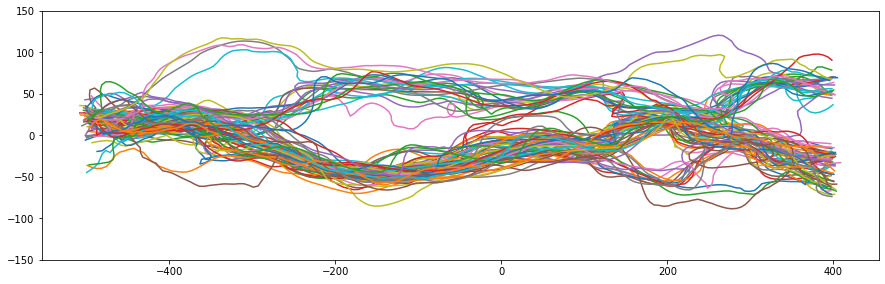

In [11]:
newKey_template = 'traj_coeff_{}'

fig,ax = plt.subplots(1,1, figsize=(15,10))
ax.set_aspect('equal')

for date in traj_dates:

    cur_key = newKey_template.format(date)
    traj = pd.read_hdf(hdf_file, key=cur_key)

    ax.plot(traj.x, traj.y)
    ax.set_ylim([-150, 150])